Outputs for Cases_TDR=0:
          system_cost           carbon wave_capacity wave_profit
0    4437460464.37639   7203835.851327      0.244908   -0.000001
1   5106089610.947909  12190000.000002      0.136675         0.0
2   5367596544.939294  12190000.000002      0.050551   -0.000023
3   5474566021.973928  12190000.000001      0.032153   -0.000018
4   5531656198.544436  12190000.000001      0.006596   -0.000002
5   4761887921.230407  12190000.000001      0.237994    0.000003
6   5287460229.581876  12190000.000002      0.117055    0.000004
7   5467683127.575534  12190000.000002      0.040504   -0.000008
8   5533630126.255751  12190000.000001      0.003984   -0.000001
9   5534060204.096615  12190000.000001           0.0         0.0
10  4947298113.059187  12190000.000002      0.219323    0.000002
11   5382456905.92612  12190000.000002      0.067775    0.000008
12   5518299069.50449  12190000.000001      0.024691   -0.000005
13  5534060204.096766  12190000.000002           0.0         0.0


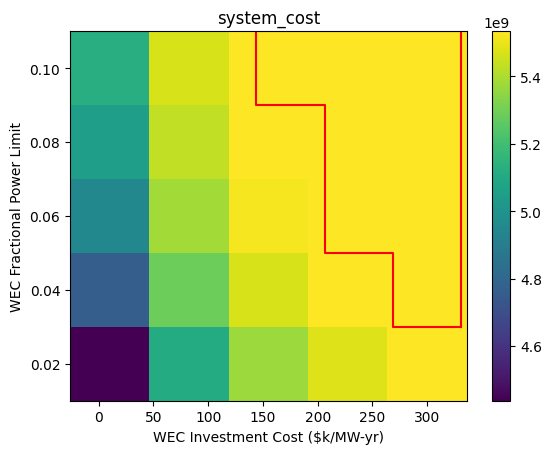

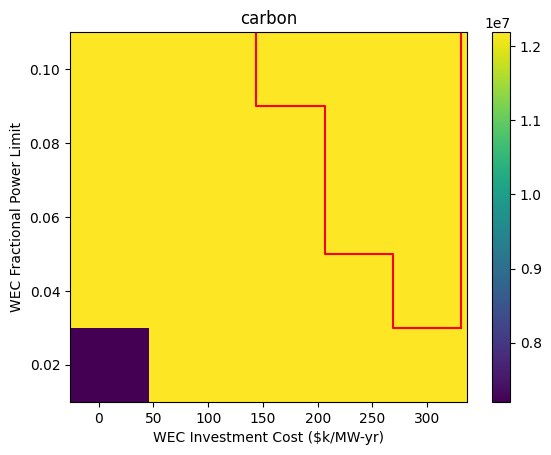

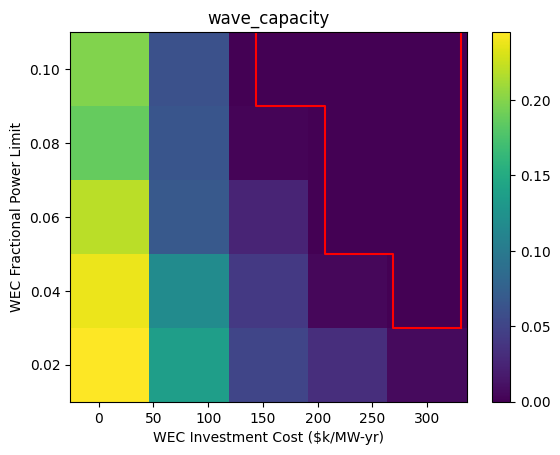

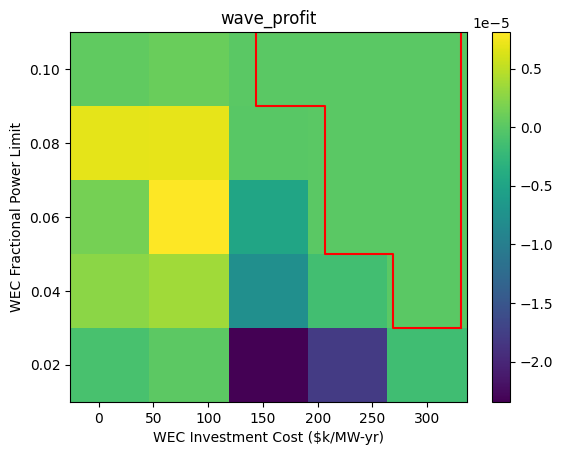

Outputs for Cases_TDRCO2=0:
          system_cost           carbon wave_capacity wave_profit
0   3612137297.506302   1221064.432046      0.646707   -0.000001
1   4823050481.633639   9380285.291844      0.210686    0.000006
2   5173092163.370557  20653632.218737           0.0         0.0
3    5173092163.36998  20653632.218737           0.0         0.0
4   5173092163.370823  20653632.218737           0.0         0.0
5   3955463788.810098   3746609.527558      0.534505   -0.000001
6   5105266213.009644  15121005.650771      0.146035    0.000011
7   5173092163.370843  20653632.216021           0.0         0.0
8   5173092163.370098  20653632.218737           0.0         0.0
9   5173092163.370955  20653632.218737           0.0         0.0
10  4142037927.611483   5676749.017795      0.536251    0.000001
11   5168707887.14021  18879714.195394      0.035324         0.0
12  5173092163.371059  20653632.191756           0.0         0.0
13  5173092163.370585  20653632.191756           0.0         0

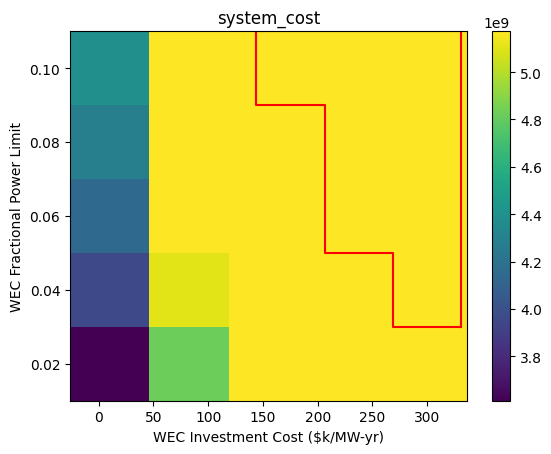

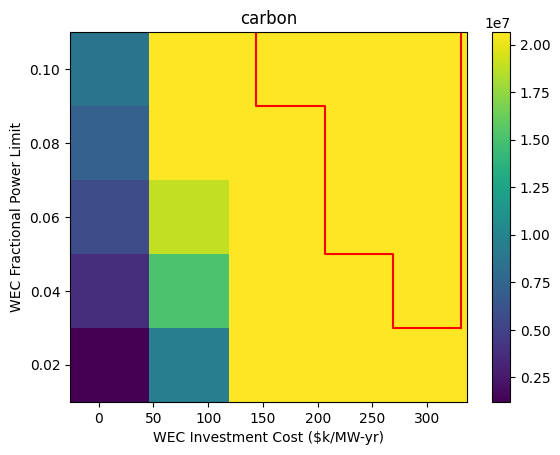

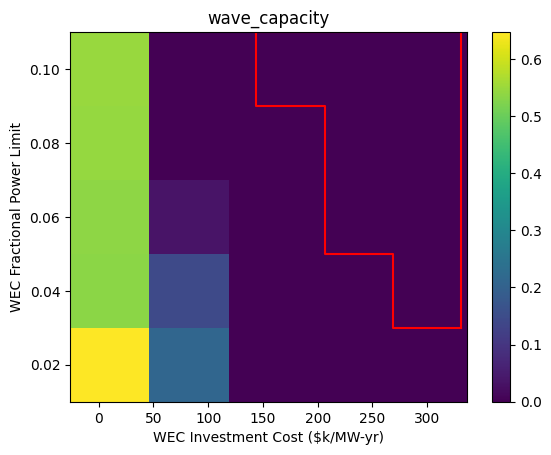

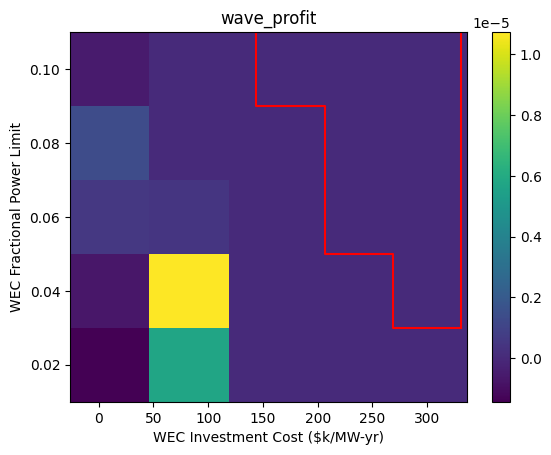

Outputs for Cases_TDRCO2_On:
          system_cost           carbon wave_capacity wave_profit
0   3787702338.096014   4382699.189534      0.279063         0.0
1    4790209615.23755  11749974.590781       0.20596   -0.000004
2   5140558908.494493  12190000.000001      0.118363   -0.000005
3   5620389321.562305  12190000.000001      0.041112    0.000006
4   5520121274.384496  12190000.000001      0.039359         0.0
5   4385655154.242744  10728769.660506      0.278759    0.000001
6   5133766556.257819  12190000.000001      0.160905         0.0
7   5472739542.500685  12190000.000001      0.086882         0.0
8   5734400504.483357  12190000.000002      0.007446         0.0
9   5736360520.645943       12190000.0           0.0         0.0
10  4820853361.821641  12190000.000001      0.243539         0.0
11  5300028053.291394  12190000.000001      0.161596   -0.000002
12  5650755767.916533  12190000.000001      0.091649    0.000003
13   5652568806.83308  12190000.000001      0.014727        -

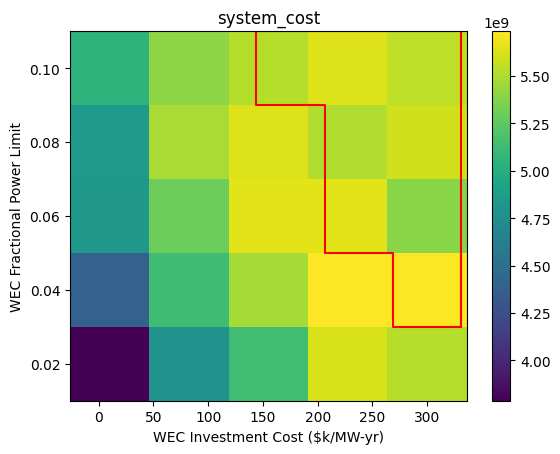

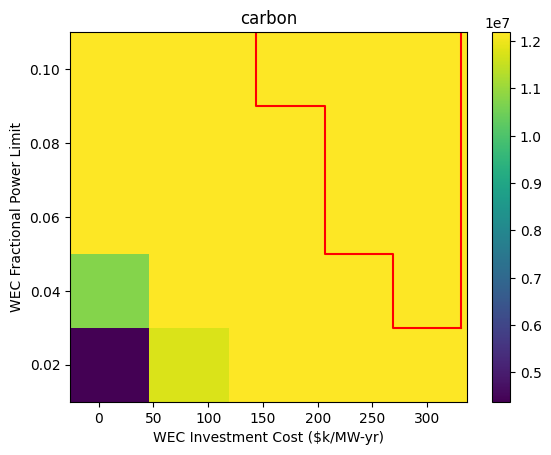

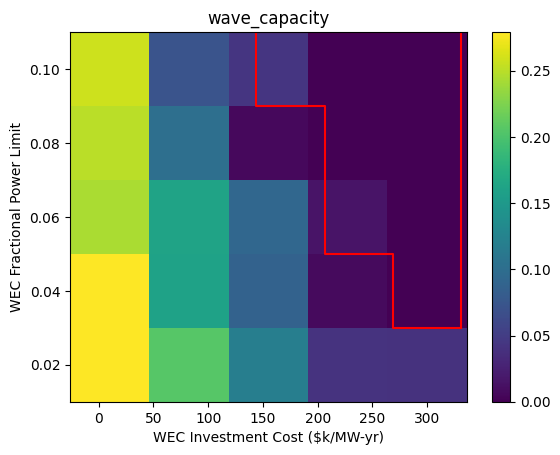

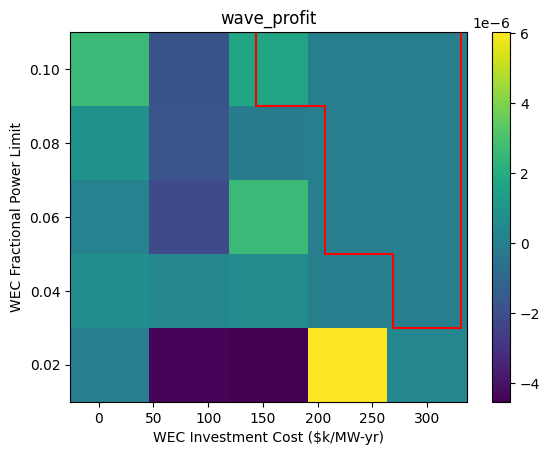

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
##no package issues

inputs = pd.read_csv('replacements.csv')
result_folders = ['Cases_TDR=0', 'Cases_TDRCO2=0', 'Cases_TDRCO2_On']
output_cols = ['system_cost', 'carbon', 'wave_capacity','wave_profit']
outputs = pd.DataFrame(index=inputs.index, columns=output_cols)

#original code for reference
#for case in np.arange(1,len(inputs)+1):
    #idx = case-1
    #result_folder = os.path.join('Cases_TDR=0','case_'+str(case),'Results')
    #cost_file     = os.path.join(result_folder,'costs.csv')
    #carbon_file   = os.path.join(result_folder,'emissions.csv')
    #capacity_file = os.path.join(result_folder,'capacity.csv')
    #revenue_file  = os.path.join(result_folder,'NetRevenue.csv')

    #system_cost_df   = pd.read_csv(cost_file,     index_col='Costs')
    #carbon_df        = pd.read_csv(carbon_file,   index_col='Zone', nrows=3)
    #wave_capacity_df = pd.read_csv(capacity_file, index_col='Resource',usecols=['Resource','EndCap'])
    #wave_profit_df   = pd.read_csv(revenue_file,  index_col='Resource',usecols=['Resource','Profit'])
    
    #system_cost = system_cost_df['Total'].loc['cTotal']
    #carbon = carbon_df['Total'].loc['AnnualSum']
    #wave_profit = wave_profit_df['Profit'].loc['NENGREST_wave']
    #wave_capacity = wave_capacity_df['EndCap'].loc['NENGREST_wave'] / wave_capacity_df['EndCap'].loc['Total']
    #outputs.loc[idx] = [system_cost,carbon,wave_capacity,wave_profit]

#print(outputs)

#new code that incorporates all folders
for result_folder in result_folders:
    for case in np.arange(1,len(inputs)+1):
        idx = case-1
        case_result_folder = os.path.join(result_folder,'case_'+str(case),'Results')
        cost_file     = os.path.join(case_result_folder,'costs.csv')
        carbon_file   = os.path.join(case_result_folder,'emissions.csv')
        capacity_file = os.path.join(case_result_folder,'capacity.csv')
        revenue_file  = os.path.join(case_result_folder,'NetRevenue.csv')

        system_cost_df   = pd.read_csv(cost_file,     index_col='Costs')
        carbon_df        = pd.read_csv(carbon_file,   index_col='Zone', nrows=3)
        wave_capacity_df = pd.read_csv(capacity_file, index_col='Resource',usecols=['Resource','EndCap'])
        wave_profit_df   = pd.read_csv(revenue_file,  index_col='Resource',usecols=['Resource','Profit'])
    
        system_cost = system_cost_df['Total'].loc['cTotal']
        carbon = carbon_df['Total'].loc['AnnualSum']
        wave_profit = wave_profit_df['Profit'].loc['NENGREST_wave']
        wave_capacity = wave_capacity_df['EndCap'].loc['NENGREST_wave'] / wave_capacity_df['EndCap'].loc['Total']
        outputs.loc[idx] = [system_cost,carbon,wave_capacity,wave_profit]

    outputs.reset_index(drop=True, inplace=True)
    print(f"Outputs for {result_folder}:")
    print(outputs)

    square_size = np.sqrt(inputs.waveInvCost.size).astype(int)
    square_tuple = (square_size, square_size)

    wec_cost = np.reshape(inputs.waveInvCost.values, square_tuple)
    power_lim = np.reshape(inputs.Notes.values, square_tuple)

    x = 250/8
    points = np.array([[300+x,   0.03],
                       [300-x,   0.03],
                       [300-x,   0.05],
                       [300-3*x, 0.05],
                       [300-3*x, 0.09],
                       [300-5*x, 0.09],
                       [300-5*x, 0.11],
                       [300+x,   0.11],
                       [300+x,   0.03]])
    
    for output in output_cols:
        output_reshaped = np.reshape(outputs[output].values, square_tuple)
        fig, ax = plt.subplots()
        plt.pcolormesh(wec_cost/1000, power_lim, output_reshaped.astype(float))
        plt.plot(points[:,0], points[:,1], 'r')
        plt.title(output)
        plt.xlabel('WEC Investment Cost ($k/MW-yr)')
        plt.ylabel('WEC Fractional Power Limit')
        plt.colorbar()
        plt.show()    
    
    
#keep old code for reference   
#square_size = np.sqrt(inputs.waveInvCost.size).astype(int)
#square_tuple = (square_size,square_size)

#wec_cost  = np.reshape(inputs.waveInvCost.values, square_tuple)
#power_lim = np.reshape(inputs.Notes.values,       square_tuple)

# hardcoded based on result - in the future do this programatically
#x = 250/8
#points = np.array([[300+x,   0.03],
                   #[300-x,   0.03],
                   #[300-x,   0.05],
                   #[300-3*x, 0.05],
                   #[300-3*x, 0.09],
                   #[300-5*x, 0.09],
                   #[300-5*x, 0.11],
                   #[300+x,   0.11],
                   #[300+x,   0.03]])

#for output in output_cols:
    #output_reshaped = np.reshape(outputs[output].values, square_tuple)
    #fig, ax = plt.subplots()
    #print(output_reshaped)
    #plt.pcolormesh(wec_cost/1000,power_lim,output_reshaped.astype(float))
    #plt.plot(points[:,0],points[:,1],'r')
    #plt.title(output)
    #plt.xlabel('WEC Investment Cost ($k/MW-yr)')
    #plt.ylabel('WEC Fractional Power Limit')
    #plt.colorbar()
    #plt.show()